In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 192 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import yfinance as yf


In [ ]:
tickers = "AAPL MSFT KO SPY"  # please do it with spaces "AAPL MSFT SPY" example
#ticker_pagar = "ASIANPAINT.NS YESBANK.NS REDINGTON.NS HINDUNILVR.NS PIDILITIND.NS ^NSEI"
ticker_pagar_REIT = ""
# Make sure SPY or the country benchmark is their always last

risk_free_rate = 1.069 # should be for country where that stock is based. Not sure if yfinance has this
period = "7y" # the time period for which you want the capm to be built
ticker_list = tickers.split(" ") #storing tickers seperately for reference
Market = ticker_list[-1]
ticker_list

['AAPL', 'MSFT', 'KO', 'SPY']

Data Creation and Cleaning 

In [ ]:

#function to create desired dataset
def create_dataset(ticker_list):
  raw_data = yf.download(ticker_list[0], interval='1d', period=period)
  raw_data['{}'.format(ticker_list[0])] = (raw_data['Open'] + raw_data['Close'])/2
  #ticker column is the mid price


  output_data = raw_data.filter(['Date','{}'.format(ticker_list[0])])
  if len(ticker_list) < 2:
    return output_data

#looping to add all each tickers data
  for i in range(1,len(ticker_list)):
    data = yf.download(ticker_list[i], interval='1d', period=period)
    data['{}'.format(ticker_list[i])] = (data['Open'] + data['Close'])/2
    output_data['{}'.format(ticker_list[i])] = data['{}'.format(ticker_list[i])]

  return output_data

#function to create a dataset with returns
def normalize(df):
  x = df.copy()
  for i in x.columns[0:]:
    x[i] = x[i]/x[i][0]
  return x


In [ ]:
prices_df = create_dataset(ticker_list)
prices_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,KO,SPY
Date,,,,
2015-11-05,30.346250,54.435001,42.165001,210.289993
2015-11-06,30.271250,54.504999,41.965000,209.889999
2015-11-09,30.191250,54.355000,41.620001,208.695000
2015-11-10,29.208750,53.789999,41.605000,208.034996
2015-11-11,29.060000,53.675001,41.990000,208.310005
...,...,...,...,...
2022-10-31,153.250000,232.945000,60.179998,386.324997
2022-11-01,152.864998,231.385002,59.834999,387.330002
2022-11-02,146.989998,224.780006,59.225000,379.384995


In [ ]:
returns_df = normalize(prices_df)
returns_df

,AAPL,MSFT,KO,SPY
Date,,,,
2015-11-05,1.000000,1.000000,1.000000,1.000000
2015-11-06,0.997529,1.001286,0.995257,0.998098
2015-11-09,0.994892,0.998530,0.987075,0.992415
2015-11-10,0.962516,0.988151,0.986719,0.989277
2015-11-11,0.957614,0.986038,0.995850,0.990584
...,...,...,...,...
2022-10-31,5.050047,4.279324,1.427250,1.837106
2022-11-01,5.037360,4.250666,1.419068,1.841885
2022-11-02,4.843762,4.129329,1.404601,1.804104


In [ ]:
Market

'SPY'

In [ ]:
# this code block is in case we dont want our market index data in the same dataset
# here we are creating an market index dataset because this is a measure of the market return
''' market_ticker = "SPY"
ticker_list = market_ticker.split(" ")
market_price_df = create_dataset(ticker_list)
market_returns_df = normalize(market_price_df)'''


' market_ticker = "SPY"\nticker_list = market_ticker.split(" ")\nmarket_price_df = create_dataset(ticker_list)\nmarket_returns_df = normalize(market_price_df)'

Interactive Plots and the function

In [ ]:
#Function to plot interactive plot
def interactive_plot(df,title):
  fig = px.line(title = title)
  for i in df.columns[0:]:
    fig.add_scatter(x = df.index, y=df[i], name = i)
  fig.show()

In [ ]:
interactive_plot(prices_df,"Price_Chart")

In [ ]:
interactive_plot(returns_df,"Returns_Chart")

Finding Beta aka Correlation of the stock with the market

AAPL


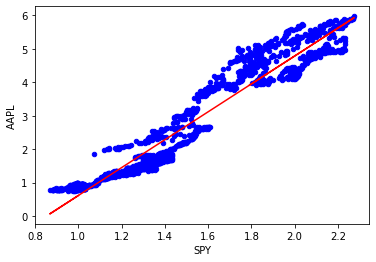

MSFT


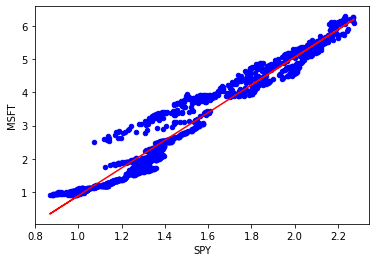

KO


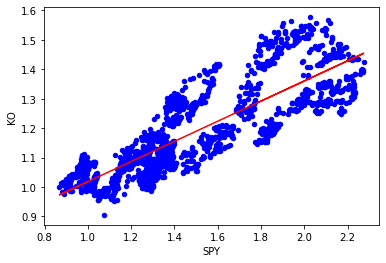

In [ ]:
beta = []
alpha = []

# Loop on every stock daily return
for i in returns_df.columns:

  # Ignoring the Market Index Columns 
  if i != Market:
    # plot a scatter plot between each individual stock and the Market
    returns_df.plot(kind = 'scatter', x = Market, y = i, color = 'b')
    print(i)
    # Fit a polynomial between each stock and the S&P500 (Poly with order = 1 is a straight line)
    b, a = np.polyfit(returns_df[Market], returns_df[i], 1)
    plt.plot(returns_df[Market], b *(returns_df[Market]) + a, '-', color = 'r')
    
    beta.append(b)
    
    alpha.append(a)
    
    plt.show()

Calculating returns using CAPM

In [ ]:
def expected_return(beta,alpha): #based on CAPM formula
  output={}
  for i in range(0,len(ticker_list)-1):  
    avg_market_return = np.e**(np.log(returns_df[Market][-1])/float(period[:-1]))  # calculate the CAGR for the market
    expected = risk_free_rate + beta[i]*(avg_market_return - risk_free_rate) # using CAPM to get expected return
    output.update({ticker_list[i]:expected})
    print(ticker_list[i],expected)
  return output, avg_market_return



In [ ]:
expected_dict,avg_market_return = expected_return(beta,alpha)
expected_dict

AAPL 1.1433274583417021
MSFT 1.1434589171385963
KO 1.0750972576465045


{'AAPL': 1.1433274583417021,
 'MSFT': 1.1434589171385963,
 'KO': 1.0750972576465045}

In [ ]:
beta

[4.167264580796456, 4.174634987377728, 0.3418505946141437]

Sharpe Ratio for the Specific Stocks